In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scanpy as sc
from gprofiler import GProfiler

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
os.chdir(myDir)
import ProxseqClasses as PC
import calculateweightedPPI as WPPI
import ProxseqFunctions as PF

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [2]:
save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update/'

In [3]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

In [4]:
adata = sc.read_h5ad('GPS/20250521/adata_mrna_annotated.h5ad')

In [5]:
#raw count data
ctrl_data = pd.read_csv('GPS/20250521/Ctrl_count_matrix.txt.gz',sep="\t",index_col=0)
cona_data = pd.read_csv('GPS/20250521/ConA_count_matrix.txt.gz',sep="\t",index_col=0)

In [6]:
all_protein_list = [
    "CD45", "CD47", "CD48", "CD44", "CD2", "CD3", "CD4", "CD8", "CD5", "CD7",
    "CD27", "CD45RA", "CD45RO", "CD62L", "CCR5", "CCR7", "CD127", "CD25", "CD28",
    "CD137", "CD154", "CD150", "CD38", "PD1", "TIM-3", "LAG-3", "CTLA-4",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CXCR3",
    "CXCR4", "CD11a", "CD49e", "CD29", "ICAM-1", "CD81", "CD147", "free_oligo"]

all_lectin_list = [
    "PHA-L", "PHA-E", "DSL", "ConA", "PNA", "MAL-I", "MAL-II", "SNA", "DBA",
    "ECA", "AAL", "LEL", "GSL-II", "Galectin-3", "UEA-I", "free_oligo"]

In [7]:
# Construct the full index list
index_list = [f'{protein}:{lectin}' for protein in all_protein_list for lectin in all_lectin_list]

# Reindex both datasets to ensure all indices exist, fill missing with 0
ctrl_target = ctrl_data.reindex(index_list).fillna(0)
cona_target = cona_data.reindex(index_list).fillna(0)

# Remove the 'free_oligo:free_oligo' row if present
ctrl_target = ctrl_target.loc[~ctrl_target.index.str.contains('free_oligo:free_oligo')]
cona_target = cona_target.loc[~cona_target.index.str.contains('free_oligo:free_oligo')]

In [8]:
df_pla_all = pd.concat([ctrl_target, cona_target], axis=1)
df_pla_all = df_pla_all.T
common_cells = df_pla_all.index.intersection(adata.obs_names)
df_pla_all = df_pla_all.loc[common_cells]
df_pla_all = df_pla_all[~df_pla_all.index.duplicated(keep='first')]

In [9]:
clr_pla_all = df_pla_all.apply(clr_function,axis=1)

In [10]:
# Make sure df_pla_all is cells x features
adata_pla = sc.AnnData(clr_pla_all)
adata_pla.obs = adata.obs.loc[adata_pla.obs_names]  # Attach original metadata
adata_pla.raw = adata_pla.copy()
sc.pp.scale(adata_pla, max_value=10)

In [ ]:
output_dir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/"
os.makedirs(output_dir, exist_ok=True)

cell_types_of_interest = [
    "CD4+ Naive T cells", "CD4+ Central Memory", "CD4+ Effector Memory",
    "CD8+ Naive T cells", "CD8+ Central Memory", "CD8+ Effector Memory", "CD8+ Effector Memory RA",
    "Treg", "NK cells_CD56+CD16+", "NK cells_CD56+CD16-"
]

for cell_type in cell_types_of_interest:
    adata_sub = adata_pla[adata_pla.obs["manual_annotation"] == cell_type].copy()

    if adata_sub.obs["condition"].nunique() < 2:
        print(f"Skipping {cell_type}: only one condition present.")
        continue

    try:
        sc.tl.rank_genes_groups(
            adata_sub,
            groupby='condition',
            method='wilcoxon',
            use_raw=False
        )


        sc.pl.rank_genes_groups_matrixplot(
            adata_sub,
            n_genes=10,
            vmin=-3,
            vmax=3,
            cmap='RdBu_r',
            figsize=(10, 7),
            swap_axes=True,
            use_raw=False,
            show=False
        )
        
        plt.savefig(output_dir + f"{cell_type.replace(' ', '_').replace('/','_')}_pla_matrix_ctrl_sti.pdf")
        # Move file from ./figures/ to your desired folder

        print(f"Saved heatmap for {cell_type} to {dst_path}")

    except Exception as e:
        print(f"Failed on {cell_type}: {e}")

compare cell types within same condition, e.g. control

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future ver

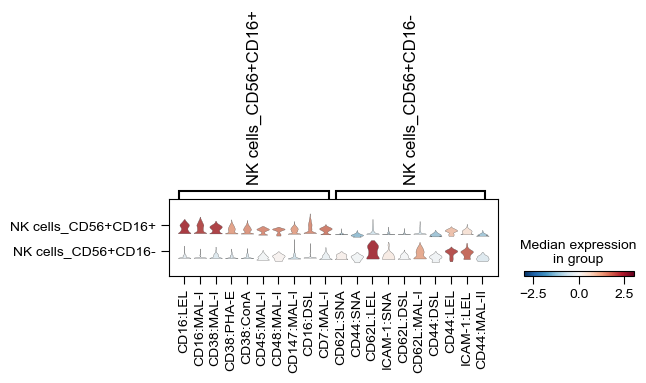

In [11]:
# 1. Subset to control cells
adata_control = adata_pla[adata_pla.obs["condition"] == "control"].copy()

# 2. Subset to CD56+CD16+ and CD56+CD16- NK cells
nk_subtypes = ["NK cells_CD56+CD16+", "NK cells_CD56+CD16-"]
adata_nk = adata_control[adata_control.obs["manual_annotation"].isin(nk_subtypes)].copy()

# 3. Run differential expression: compare NK subtypes
sc.tl.rank_genes_groups(
    adata_nk,
    groupby="manual_annotation",
    method="wilcoxon",
    use_raw=False
)

# 4. Visualize top DE PLA markers
sc.pl.rank_genes_groups_stacked_violin(
    adata_nk,
    n_genes=10,
    #values_to_plot="logfoldchanges",
    dendrogram=False,
    vmin=-3,
    vmax=3,
    cmap='RdBu_r',
    figsize=(6, 1),
    swap_axes=False,
    use_raw=False,
    show=False
)
plt.savefig(save_dir + "nk_pla.svg", format='svg', bbox_inches='tight', pad_inches=0)

In [12]:
#get protein and lectin data
ctrl_raw_lectin = pd.read_csv('GPS/20250521/ctrl_raw_lectin.csv', index_col=0)
ctrl_raw_protein = pd.read_csv('GPS/20250521/ctrl_raw_protein.csv', index_col=0)
clr_lectin = ctrl_raw_lectin.apply(clr_function, axis=0)
clr_protein = ctrl_raw_protein.apply(clr_function, axis=0)

In [13]:
#create lectin object and protein object
clr_lectin = clr_lectin[adata_control.obs_names].T
clr_protein = clr_protein[adata_control.obs_names].T
clr_lectin = clr_lectin[~clr_lectin.index.duplicated(keep='first')]
clr_protein = clr_protein[~clr_protein.index.duplicated(keep='first')]
adt_adata = sc.AnnData(clr_protein)
ldt_adata = sc.AnnData(clr_lectin)
# Make sure df_pla_all is cells x features
adt_adata.obs = adata.obs.loc[adt_adata.obs_names]  # Attach original metadata
ldt_adata.obs = adata.obs.loc[ldt_adata.obs_names]  # Attach original metadata
ldt_adata.raw = ldt_adata.copy()
adt_adata.raw = adt_adata.copy()
sc.pp.scale(adt_adata, max_value=10)
sc.pp.scale(ldt_adata, max_value=10)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future ver

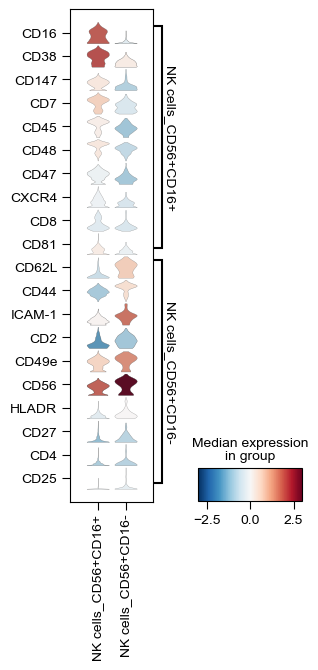

In [14]:
# 2. Subset to CD56+CD16+ and CD56+CD16- NK cells
nk_subtypes = ["NK cells_CD56+CD16+", "NK cells_CD56+CD16-"]
adt_nk = adt_adata[adt_adata.obs["manual_annotation"].isin(nk_subtypes)].copy()

# 3. Run differential expression: compare NK subtypes
sc.tl.rank_genes_groups(
    adt_nk,
    groupby="manual_annotation",
    method="wilcoxon",
    use_raw=False
)

# 4. Visualize top DE PLA markers
sc.pl.rank_genes_groups_stacked_violin(
    adt_nk,
    vmin=-3,
    vmax=3,
    cmap='RdBu_r',
    figsize=(3, 6),
    swap_axes=True,
    use_raw=False,
    show=False
)
plt.savefig(save_dir + "nk_adt.svg", format='svg', bbox_inches='tight', pad_inches=0)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pa

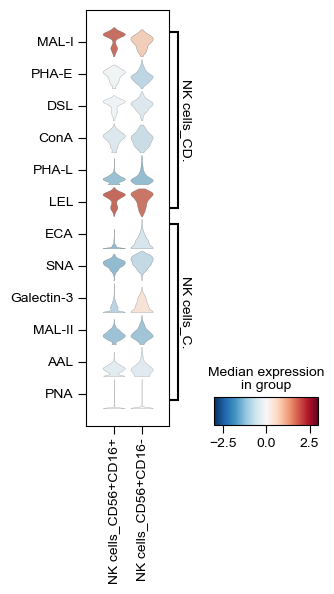

In [15]:
# 2. Subset to CD56+CD16+ and CD56+CD16- NK cells
nk_subtypes = ["NK cells_CD56+CD16+", "NK cells_CD56+CD16-"]
ldt_nk = ldt_adata[ldt_adata.obs["manual_annotation"].isin(nk_subtypes)].copy()

# 3. Run differential expression: compare NK subtypes
sc.tl.rank_genes_groups(
    ldt_nk,
    groupby="manual_annotation",
    method="wilcoxon",
    use_raw=False
)

# 4. Visualize top DE PLA markers
sc.pl.rank_genes_groups_stacked_violin(
    ldt_nk,
    n_genes=6,
    vmin=-3,
    vmax=3,
    cmap='RdBu_r',
    figsize=(3, 5),
    swap_axes=True,
    use_raw=False,
    show=False
)
plt.savefig(save_dir + "nk_ldt.svg", format='svg', bbox_inches='tight', pad_inches=0)

In [124]:
ldt_nk.uns['rank_genes_groups']

{'params': {'groupby': 'manual_annotation',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('MAL-I', 'ECA'), ('PHA-E', 'SNA'), ('DSL', 'Galectin-3'),
            ('ConA', 'MAL-II'), ('PHA-L', 'AAL'), ('LEL', 'PNA'),
            ('DBA', 'GSL-II'), ('UEA-I', 'UEA-I'), ('GSL-II', 'DBA'),
            ('PNA', 'LEL'), ('AAL', 'PHA-L'), ('MAL-II', 'ConA'),
            ('Galectin-3', 'DSL'), ('SNA', 'PHA-E'), ('ECA', 'MAL-I')],
           dtype=[('NK cells_CD56+CD16+', 'O'), ('NK cells_CD56+CD16-', 'O')]),
 'scores': rec.array([( 8.23069   ,  9.70117   ), ( 5.1539693 ,  6.504888  ),
            ( 2.5734205 ,  4.8180757 ), ( 2.1325467 ,  1.896881  ),
            ( 0.6144369 ,  0.7501985 ), ( 0.22562116,  0.3402138 ),
            (-0.01036842,  0.26785088), (-0.06825877,  0.06825877),
            (-0.26785088,  0.01036842), (-0.3402138 , -0.22562116),
            (-0.7501985 , -0.6144369 ), (-1.8968

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


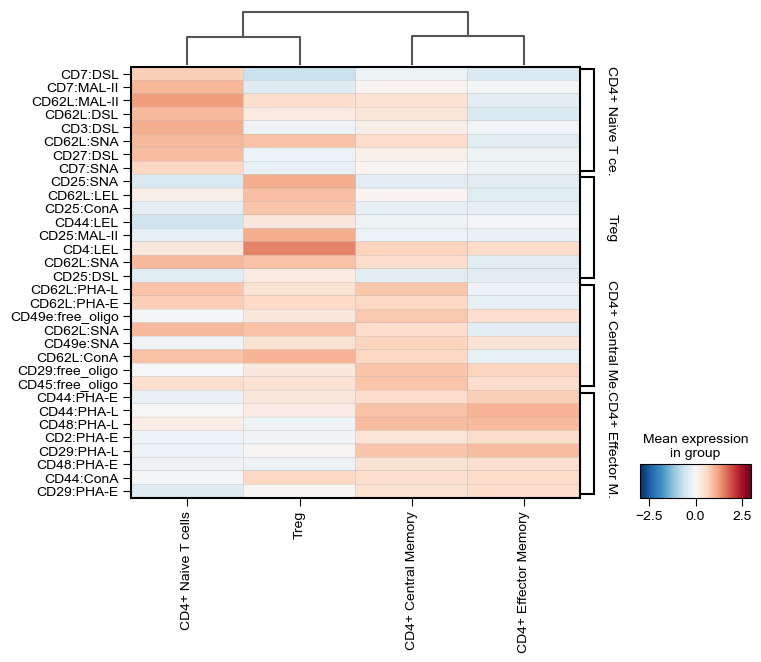

In [153]:
#CD4 Naive, T cm, Tem 
cd4_subtypes = ["CD4+ Naive T cells", "CD4+ Central Memory", "CD4+ Effector Memory", 'Treg']
adata_cd4 = adata_control[adata_control.obs["manual_annotation"].isin(cd4_subtypes)].copy()

# 3. Run DE across subtypes
sc.tl.rank_genes_groups(
    adata_cd4,
    groupby="manual_annotation",
    method="wilcoxon",
    use_raw=False
)

sc.pl.rank_genes_groups_matrixplot(
    adata_cd4,
    n_genes=8,
    vmin=-3,
    vmax=3,
    cmap='RdBu_r',
    figsize=(8, 6),
    swap_axes=True,
    use_raw=False,
    show=True
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


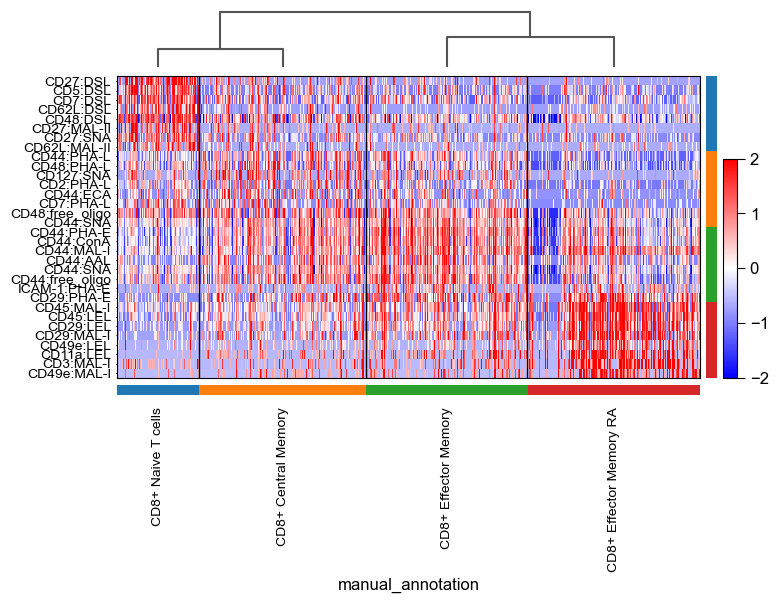

In [156]:
#CD8 Naive, Tcm, Tem, Temra
cd8_subtypes = ["CD8+ Naive T cells", "CD8+ Central Memory", "CD8+ Effector Memory", "CD8+ Effector Memory RA"]
adata_cd8 = adata_control[adata_control.obs["manual_annotation"].isin(cd8_subtypes)].copy()

# 3. Run DE across subtypes
sc.tl.rank_genes_groups(
    adata_cd8,
    groupby="manual_annotation",
    method="wilcoxon",
    use_raw=False
)

sc.pl.rank_genes_groups_heatmap(
    adata_cd8,
    n_genes=8,
    vmin=-2,
    vmax=2,
    cmap='bwr',
    figsize=(8, 5),
    swap_axes=True,
    use_raw=False,
    show=True
)

In [16]:
# Define common NK subsets
nk_types = ["NK cells_CD56+CD16+", "NK cells_CD56+CD16-"]

# Subset NK cells
adata_nk = adata[adata.obs["manual_annotation"].isin(nk_types)].copy()
# Normalize and log1p using the counts layer
sc.pp.normalize_total(adata_nk, target_sum=1e4, layer='counts')
sc.pp.log1p(adata_nk, layer='counts')

# Set group labels
adata_nk.obs["nk_group"] = adata_nk.obs["manual_annotation"]

# Run DE: CD56+CD16+ vs CD56+CD16-
sc.tl.rank_genes_groups(
    adata_nk,
    groupby="nk_group",
    groups=["NK cells_CD56+CD16+"],
    reference="NK cells_CD56+CD16-",
    method="wilcoxon",
    use_raw=False,
    layer="counts",  # make sure to use the correct layer
    pts=True
)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from adjustText import adjust_text

def volcano_plot(
    de_df,
    logfc_col='logfoldchanges',
    pval_col='pvals_adj',
    gene_col='names',
    logfc_thresh=0.5,
    pval_thresh=0.05,
    label_genes=None,
    figsize=(8,6),
    title='Volcano Plot',
    ax=None,
    base_dot_size=20,
    highlight_dot_size=60,
    up_color='#E64B35',
    down_color='#4DBBD5',
    default_color='gray'
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    de_df = de_df.copy()
    de_df[pval_col] = de_df[pval_col].replace(0, 1e-300)
    de_df['neg_log10_pval'] = -np.log10(de_df[pval_col])

    # Define color logic
    def assign_color(row):
        if row[logfc_col] >= logfc_thresh and row[pval_col] < pval_thresh:
            return up_color
        elif row[logfc_col] <= -logfc_thresh and row[pval_col] < pval_thresh:
            return down_color
        else:
            return default_color

    de_df['color'] = de_df.apply(assign_color, axis=1)

    # Plot all points
    ax.scatter(
        de_df[logfc_col],
        de_df['neg_log10_pval'],
        c=de_df['color'],
        s=base_dot_size,
        alpha=0.7,
        edgecolor='none',
        rasterized=True
    )

    # Threshold lines
    ax.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    ax.axvline(logfc_thresh, color='black', linestyle='--', linewidth=1)
    ax.axvline(-logfc_thresh, color='black', linestyle='--', linewidth=1)

    # Label selected genes
    texts = []
    if label_genes is not None:
        subset = de_df[de_df[gene_col].isin(label_genes)]
        for _, row in subset.iterrows():
            texts.append(
                ax.text(
                    row[logfc_col],
                    row['neg_log10_pval'],
                    row[gene_col],
                    fontsize=8,
                    ha='right' if row[logfc_col] < 0 else 'left',
                    va='bottom',
                    color='black'
                )
            )
            ax.scatter(
                row[logfc_col],
                row['neg_log10_pval'],
                c=row['color'],
                s=highlight_dot_size,
                edgecolor='k',
                linewidth=1.0,
                zorder=3,
                rasterized=True
            )

    # Adjust text positions
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='black')
    )

    # Final plot settings
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_title(title)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5, 100)

    # Dot-style legend
    legend_elements = [
        mlines.Line2D([], [], color=default_color, marker='o', linestyle='None',
                      markersize=8, label='NS'),
        mlines.Line2D([], [], color=down_color, marker='o', linestyle='None',
                      markersize=8, label='Down'),
        mlines.Line2D([], [], color=up_color, marker='o', linestyle='None',
                      markersize=8, label='Up')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False)

    plt.tight_layout()
    return ax

In [19]:
glyco_genes = [
    "A4GALT", "A4GNT", "ABO", "AGA", "ALG1", "ALG10", "ALG10B", "ALG11", "ALG12", "ALG13",
    "ALG14", "ALG2", "ALG3", "ALG5", "ALG6", "ALG8", "ALG9", "B3GALNT1", "B3GALNT2", "B3GALT1",
    "B3GALT2", "B3GALT4", "B3GALT5", "B3GALT6", "B3GAT1", "B3GAT2", "B3GAT3", "B3GLCT", "B3GNT2",
    "B3GNT3", "B3GNT4", "B3GNT5", "B3GNT6", "B3GNT7", "B3GNT8", "B3GNT9", "B3GNTL1", "B4GALNT1",
    "B4GALNT2", "B4GALNT3", "B4GALNT4", "B4GALT1", "B4GALT2", "B4GALT3", "B4GALT4", "B4GALT5",
    "B4GALT6", "B4GALT7", "B4GAT1", "C1GALT1", "C1GALT1C1", "CHPF", "CHPF2", "CHST1", "CHST10",
    "CHST11", "CHST12", "CHST13", "CHST14", "CHST15", "CHST2", "CHST3", "CHST4", "CHST5", "CHST6",
    "CHST7", "CHST8", "CHST9", "CHSY1", "CHSY3", "CMAS", "COLGALT1", "COLGALT2", "CSGALNACT1",
    "CSGALNACT2", "DAD1", "DDOST", "DPAGT1", "DPM1", "DPM2", "DPM3", "DPY19L1", "DPY19L2",
    "DPY19L3", "DPY19L4", "DSE", "DSEL", "EGOT", "ENGASE", "EOGT", "EXT1", "EXT2", "EXTL1",
    "EXTL2", "EXTL3", "FKRP", "FKTN", "FPGT", "FUCA1", "FUCA2", "FUK", "FUT1", "FUT10", "FUT11",
    "FUT2", "FUT3", "FUT4", "FUT5", "FUT6", "FUT7", "FUT8", "FUT9", "GAL3ST1", "GAL3ST2",
    "GAL3ST3", "GAL3ST4", "GALC", "GALE", "GALK1", "GALK2", "GALNS", "GALNT1", "GALNT10",
    "GALNT11", "GALNT12", "GALNT13", "GALNT14", "GALNT15", "GALNT16", "GALNT18", "GALNT2",
    "GALNT3", "GALNT4", "GALNT5", "GALNT6", "GALNT7", "GALNT8", "GALNT9", "GALNTL5", "GALNTL6",
    "GALT", "GANAB", "GBA", "GBA2", "GBA3", "GBGT1", "GCNT1", "GCNT2", "GCNT3", "GCNT4", "GCNT6",
    "GCNT7", "GLA", "GLB1", "GLCE", "GM2A", "GMDS", "GMPPA", "GMPPB", "GNB1", "GNB2L1", "GNE",
    "GNPDA1", "GNPNAT1", "GNS", "GPI", "GUSB", "GXYLT1", "GXYLT2", "HAS1", "HAS2", "HAS3", "HEXA",
    "HEXB", "HEXD", "HGSNAT", "HK1", "HK2", "HK3", "HPSE", "HPSE2", "HS2ST1", "HS3ST1", "HS3ST2",
    "HS3ST3A1", "HS3ST3B1", "HS3ST4", "HS3ST5", "HS3ST6", "HS6ST1", "HS6ST2", "HS6ST3", "HYAL1",
    "HYAL2", "HYAL3", "HYAL4", "IDS", "IDUA", "KHK", "LARGE1", "LARGE2", "LFNG", "LGALS1",
    "LGALS12", "LGALS13", "LGALS14", "LGALS16", "LGALS2", "LGALS3", "LGALS3BP", "LGALS4",
    "LGALS7", "LGALS7B", "LGALS8", "LGALS9", "LGALS9B", "LGALS9C", "MAN1A1", "MAN1A2", "MAN1B1",
    "MAN1C1", "MAN2A1", "MAN2A2", "MAN2B1", "MAN2B2", "MAN2C1", "MANBA", "MFNG", "MGAT1", "MGAT2",
    "MGAT3", "MGAT4A", "MGAT4B", "MGAT4C", "MGAT4D", "MGAT5", "MGAT5B", "MGEA5", "MOGS", "MPI",
    "MUC1", "MUC12", "MUC13", "MUC15", "MUC16", "MUC17", "MUC19", "MUC2", "MUC20", "MUC21",
    "MUC3A", "MUC3B", "MUC4", "MUC5AC", "MUC5B", "MUC6", "MUC7", "MUC8", "MUCL1", "NAGK", "NAGLU",
    "NANP", "NANS", "NDST1", "NDST2", "NDST3", "NDST4", "NEU1", "NEU2", "NEU3", "NEU4", "NPL",
    "OGT", "OVGP1", "PGAP4", "PGM1", "PIGA", "PIGB", "PIGC", "PIGH", "PIGM", "PIGP", "PIGQ",
    "PIGV", "PIGZ", "PMM1", "PMM2", "POFUT1", "POFUT2", "POGLUT1", "POGLUT2", "POGLUT3",
    "POMGNT1", "POMGNT2", "POMK", "POMT1", "POMT2", "PSAP", "RENBP", "RFNG", "RFT1", "RPN1",
    "RPN2", "RXYLT1", "SGSH", "SLC33A1", "SLC35A1", "SLC35A2", "SLC35A3", "SLC35B1", "SLC35B2",
    "SLC35B3", "SLC35C1", "SLC35D1", "SLC35D2", "SPAM1", "ST3GAL1", "ST3GAL2", "ST3GAL3",
    "ST3GAL4", "ST3GAL5", "ST3GAL6", "ST6GAL1", "ST6GAL2", "ST6GALNAC1", "ST6GALNAC2",
    "ST6GALNAC3", "ST6GALNAC4", "ST6GALNAC5", "ST6GALNAC6", "ST8SIA1", "ST8SIA2", "ST8SIA3",
    "ST8SIA4", "ST8SIA5", "ST8SIA6", "STS", "STT3A", "STT3B", "SULF1", "SULF2", "TMEM241",
    "TMTC1", "TMTC2", "TMTC3", "TMTC4", "TPST1", "TPST2", "TSTA3", "TUSC3", "UAP1", "UGCG",
    "UGCGL1", "UGCGL2", "UGDH", "UGP2", "UGT1A1", "UGT2A1", "UGT2B10", "UGT2B17", "UGT2B28",
    "UGT2B4", "UGT8", "UST", "UXS1", "WBSCR17", "XXYLT1", "XYLT1", "XYLT2"
]

In [20]:
de_nk = sc.get.rank_genes_groups_df(adata_nk, group="NK cells_CD56+CD16+")
de_glyco = de_nk[de_nk["names"].isin(glyco_genes)].copy()

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [21]:
de_glyco

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group
63,ST3GAL4,7.832759,1.772868,4.772784e-15,9.740375e-14,0.423122
76,ST8SIA6,7.111626,3.223676,1.146837e-12,1.935589e-11,0.263498
110,COLGALT2,5.565275,1.876082,2.617388e-08,2.900153e-07,0.274061
385,CHSY3,1.056372,3.655623,2.907982e-01,7.202431e-01,0.039319
389,CHST2,1.041757,0.585121,2.975243e-01,7.319171e-01,0.176643
...,...,...,...,...,...,...
3934,UST,-10.967181,-2.048575,5.495916e-28,2.243231e-26,0.190728
3938,EXT1,-11.216507,-1.856442,3.383724e-29,1.471184e-27,0.342136
3964,MGAT5,-12.594761,-1.985780,2.256417e-36,1.529775e-34,0.327465
3980,XYLT1,-14.313806,-2.385733,1.794200e-46,2.174788e-44,0.264085


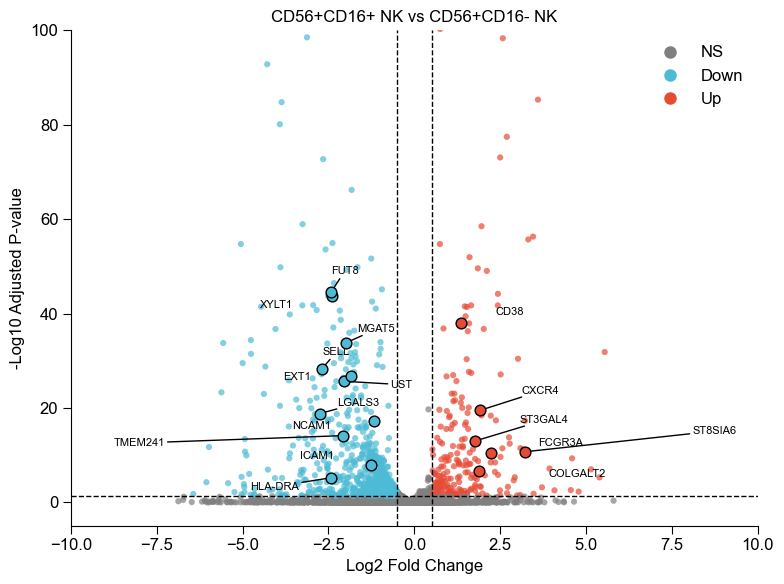

In [23]:
volcano_plot(
    de_nk,
    label_genes=['ST3GAL4','ST8SIA6','COLGALT2','MGAT5','FUT8','LGALS3','XYLT1','EXT1','UST','TMEM241',
                 'CD38','CXCR4','FCGR3A',"SELL","NCAM1","ICAM1","HLA-DRA"],
    logfc_thresh=0.5,
    pval_thresh=0.05,
    title='CD56+CD16+ NK vs CD56+CD16- NK'
)

sns.despine()
plt.savefig(save_dir + "volcano_plot_nk.svg", format='svg', bbox_inches='tight', pad_inches=0)

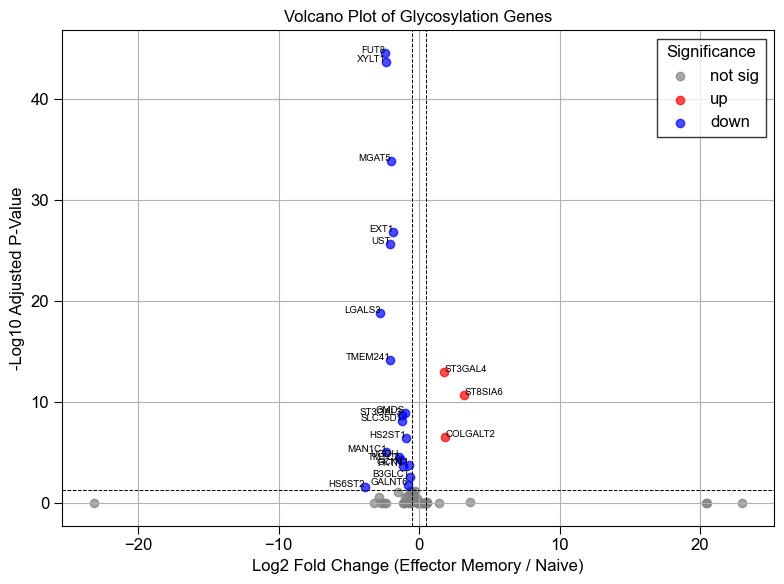

In [227]:
# Compute volcano plot axes
de_glyco["-log10(padj)"] = -np.log10(de_glyco["pvals_adj"] + 1e-300)

# Assign significance
de_glyco["significant"] = "not sig"
de_glyco.loc[(de_glyco["logfoldchanges"] > 0.5) & (de_glyco["pvals_adj"] < 0.05), "significant"] = "up"
de_glyco.loc[(de_glyco["logfoldchanges"] < -0.5) & (de_glyco["pvals_adj"] < 0.05), "significant"] = "down"

# Set color mapping
color_map = {
    "not sig": "gray",
    "up": "red",
    "down": "blue"
}

# Plot
plt.figure(figsize=(8, 6))
for sig in ["not sig", "up", "down"]:
    df = de_glyco[de_glyco["significant"] == sig]
    plt.scatter(df["logfoldchanges"], df["-log10(padj)"], c=color_map[sig], label=sig, alpha=0.7)

# Add labels to significantly changed glycosylation genes
for _, row in de_glyco.iterrows():
    if row["significant"] != "not sig":
        plt.text(
            row["logfoldchanges"], row["-log10(padj)"], row["names"],
            fontsize=7, ha='right' if row["logfoldchanges"] < 0 else 'left'
        )

# Threshold lines
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Labels
plt.xlabel("Log2 Fold Change (Effector Memory / Naive)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot of Glycosylation Genes")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Significance")
plt.show()


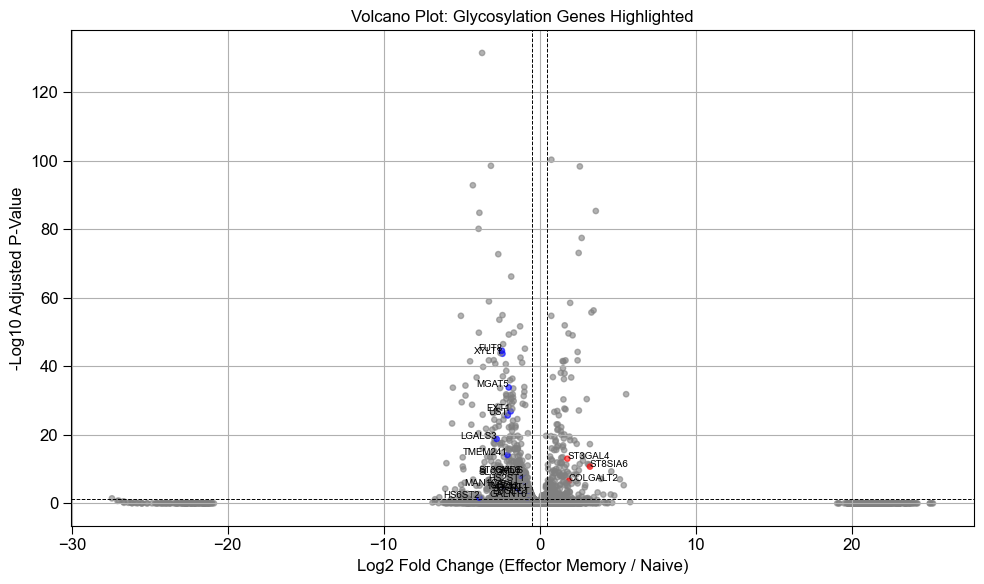

In [228]:
# Step 1: Prepare DE data
df = de_nk.copy()
df["-log10(padj)"] = -np.log10(df["pvals_adj"] + 1e-300)

# Step 2: Mark all genes as gray by default
df["color"] = "gray"

# Step 3: Highlight significant glycosylation-related genes
is_glyco = df["names"].isin(glyco_genes)
is_sig_up = (df["logfoldchanges"] > 0.5) & (df["pvals_adj"] < 0.05)
is_sig_down = (df["logfoldchanges"] < -0.5) & (df["pvals_adj"] < 0.05)

df.loc[is_glyco & is_sig_up, "color"] = "red"
df.loc[is_glyco & is_sig_down, "color"] = "blue"

# Step 4: Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(df["logfoldchanges"], df["-log10(padj)"], c=df["color"], s=15, alpha=0.6)

# Step 5: Annotate only labeled glycosylation genes
for _, row in df.loc[is_glyco & (is_sig_up | is_sig_down)].iterrows():
    plt.text(
        row["logfoldchanges"], row["-log10(padj)"], row["names"],
        fontsize=7, ha='right' if row["logfoldchanges"] < 0 else 'left'
    )

# Step 6: Add reference lines
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Step 7: Labels and formatting
plt.xlabel("Log2 Fold Change (Effector Memory / Naive)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot: Glycosylation Genes Highlighted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
protein_marker_genes = [
    "FCGR3A",  # CD16
    "CD38",
    "BSG",     # CD147
    "CD7",
    "PTPRC",   # CD45
    "CD48",
    "CD47",
    "CXCR4",
    "CD8A",    # CD8
    "CD81",
    "SELL",    # CD62L
    "CD44",
    "ICAM1",
    "CD2",
    "ITGA5",   # CD49e
    "NCAM1",   # CD56
    "HLA-DRA", # HLA-DR (alpha chain)
    "CD27",
    "CD4",
    "IL2RA"    # CD25
]


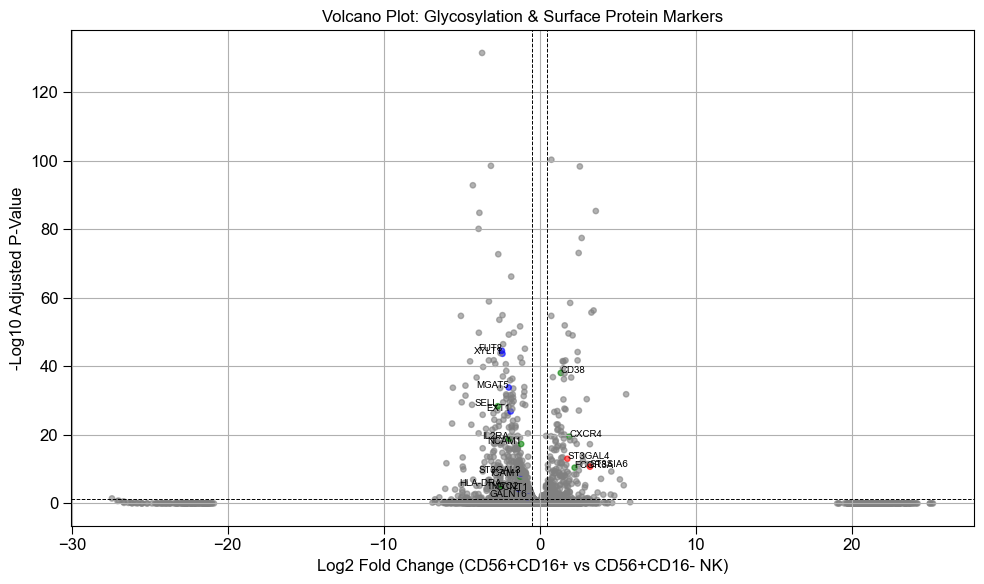

In [173]:
# Create label set: union of glyco and protein genes
genes_to_label = set(glyco_genes).union(protein_marker_genes)

# Color setup (gray base)
df["color"] = "gray"
df.loc[df["names"].isin(glyco_genes) & is_sig_up, "color"] = "red"
df.loc[df["names"].isin(glyco_genes) & is_sig_down, "color"] = "blue"
df.loc[df["names"].isin(protein_marker_genes) & (is_sig_up | is_sig_down), "color"] = "green"

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df["logfoldchanges"], df["-log10(padj)"], c=df["color"], s=15, alpha=0.6)

# Annotate glyco and protein genes
for _, row in df.loc[df["names"].isin(genes_to_label) & (is_sig_up | is_sig_down)].iterrows():
    plt.text(
        row["logfoldchanges"], row["-log10(padj)"], row["names"],
        fontsize=7, ha='right' if row["logfoldchanges"] < 0 else 'left'
    )

# Thresholds
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Labels
plt.xlabel("Log2 Fold Change (CD56+CD16+ vs CD56+CD16- NK)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot: Glycosylation & Surface Protein Markers")
plt.grid(True)
plt.tight_layout()
plt.show()
